# 图片预处理

In [1]:
import os, shutil, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle 
%matplotlib inline 

In [2]:
print("当前工作目录是:")
print(os.getcwd())

当前工作目录是:
/home/ec2-user/cat_vs_dog_cnn


In [3]:
from PIL import Image
print(Image.__file__)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py


## 清理训练集

In [4]:
bad_image_names = [
    'cat.12272.jpg', 'dog.1773.jpg', 'cat.10029.jpg', 'cat.3216.jpg', 
    'cat.5071.jpg', 'dog.6725.jpg', 'cat.7464.jpg', 'dog.1259.jpg', 
    'dog.8736.jpg', 'dog.1625.jpg', 'dog.11437.jpg', 'dog.10190.jpg', 
    'cat.10636.jpg', 'cat.5351.jpg', 'cat.8921.jpg', 'dog.1895.jpg', 
    'dog.11266.jpg', 'cat.2520.jpg', 'cat.8456.jpg', 'cat.5974.jpg', 
    'cat.3004.jpg', 'dog.12376.jpg', 'cat.4688.jpg', 'dog.4218.jpg', 
    'cat.10365.jpg', 'cat.9171.jpg', 'dog.10747.jpg', 'cat.2939.jpg', 
    'dog.5604.jpg', 'cat.11184.jpg', 'dog.7076.jpg', 'dog.6475.jpg', 
    'cat.12476.jpg', 'dog.9188.jpg', 'dog.11299.jpg', 'dog.2614.jpg', 
    'dog.10161.jpg', 'cat.4308.jpg', 'dog.4367.jpg', 'dog.8898.jpg', 
    'cat.5418.jpg', 'cat.3672.jpg', 'cat.11039.jpg', 'cat.7968.jpg', 
    'cat.12424.jpg', 'dog.10801.jpg', 'cat.7564.jpg', 'dog.1194.jpg', 
    'dog.2339.jpg', 'cat.8470.jpg', 'cat.4338.jpg', 'cat.6345.jpg', 
    'cat.9983.jpg', 'cat.1139.jpg', 'dog.7706.jpg', 'cat.10536.jpg', 
    'dog.10237.jpg', 'cat.7377.jpg', 'dog.9517.jpg', 'cat.6348.jpg', 
    'dog.3889.jpg', 'cat.10712.jpg', 'dog.4507.jpg', 'dog.2422.jpg']

### 删除明显错误，不包含猫或者狗的图片

In [5]:
# 明显错误，不包含猫或者狗的图片下标
wrong_type1_list =[0,1,2,3,8,13,18,21,25,26,28,29,31,34,35,36,38,39,40,45,46,47,50,53,56,57,58,61]
length = len(wrong_type1_list)
for i in range(0, length):
    index = wrong_type1_list[i]
    file_name= './train/' + bad_image_names[index]
    os.remove(file_name)
    
print("删除完毕")

FileNotFoundError: [Errno 2] No such file or directory: './train/cat.12272.jpg'

### 删除卡通猫狗或者两者都有的图片下标

In [6]:
# 包含卡通猫狗或者两者都有的图片下标
wrong_type3_list = [7,11,15,22,27,33,43,49]

length = len(wrong_type3_list)
for i in range(0, length):
    index = wrong_type3_list[i]
    file_name= './train/' + bad_image_names[index]
    os.remove(file_name)
    
print("删除完毕")

FileNotFoundError: [Errno 2] No such file or directory: './train/dog.1259.jpg'

### 删除背景复杂但是包含正常猫狗单一图片

In [7]:
# 背景复杂但是包含正常猫狗单一图片的图片下标
wrong_type4_list = [5,10,12,14,17,19,24,30,37,41,42,44,48,51,52,55,59,60,62,63]

length = len(wrong_type4_list)
for i in range(0, length):
    index = wrong_type4_list[i]
    file_name= './train/' + bad_image_names[index]
    os.remove(file_name)
    
print("删除完毕")

FileNotFoundError: [Errno 2] No such file or directory: './train/dog.6725.jpg'

## 定义的目录结构变量

In [8]:
# 训练集图片目录
train_images_folder = 'train'
train_set_folder = 'train1'
train_set_folder_cat = 'train1/cats/'
train_set_folder_dog = 'train1/dogs/'

# 验证集图片目录
validation_set_folder = 'valid'
validation_set_folder_cat = 'valid/cats/'
validation_set_folder_dog = 'valid/dogs/'

## 新建有关目录结构

In [9]:
def rmrf_mkdir(dirname):
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)

rmrf_mkdir(train_set_folder)
os.mkdir(train_set_folder_cat)
os.mkdir(train_set_folder_dog)

rmrf_mkdir(validation_set_folder)
os.mkdir(validation_set_folder_cat)
os.mkdir(validation_set_folder_dog)

## 加载训练集目录

In [10]:
train_filenames = os.listdir(train_images_folder)
train_cat = filter(lambda x:x[:3] == 'cat', train_filenames)
train_dog = filter(lambda x:x[:3] == 'dog', train_filenames)

In [11]:
print (type(train_cat))
print (len(train_filenames))

<class 'filter'>
24944


In [12]:
print (train_filenames[-1])

dog.1496.jpg


定义一组移动有用的函数：

In [13]:
num_of_images_valid_set = 2500
        
def move_cat_images():
    timer = 0
    for filename in train_cat:
        if timer < num_of_images_valid_set:
            shutil.copy2('train/'+filename, validation_set_folder_cat)
        else:
            shutil.copy2('train/'+filename, train_set_folder_cat)
        timer = timer + 1

def move_dog_images():
    timer = 0
    for filename in train_dog:
        if timer < num_of_images_valid_set:
            shutil.copy2('train/'+filename, validation_set_folder_dog)
        else:
            shutil.copy2('train/'+filename, train_set_folder_dog)
        timer = timer + 1  

In [14]:
def fill_train_set_valid_set_folder_with_images():
    move_cat_images()
    move_dog_images()

In [15]:
fill_train_set_valid_set_folder_with_images()
print ('fill_train_set_valid_set_folder_with_images执行完毕')

fill_train_set_valid_set_folder_with_images执行完毕


# 搭建并且编译模型

In [62]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

In [63]:
batch_size = 64
target_size = (299, 299)

# 不包含原有模型的全连接层
base_model = InceptionResNetV2(include_top=False, 
                             weights='imagenet',
                             input_shape = (299, 299, 3),
                             pooling='avg')

x = base_model.output

# x = Dense(units = 1024, activation = 'relu',  name='fc1')(x)

x = Dropout(0.8, name='dropout')(x)

# Classifier
predictions = Dense(units = 1, activation='sigmoid',  name='predictions')(x)

model = Model(inputs=base_model.input, outputs=predictions)

print("模型组装完毕！")

模型组装完毕！


## 可视化模型结构

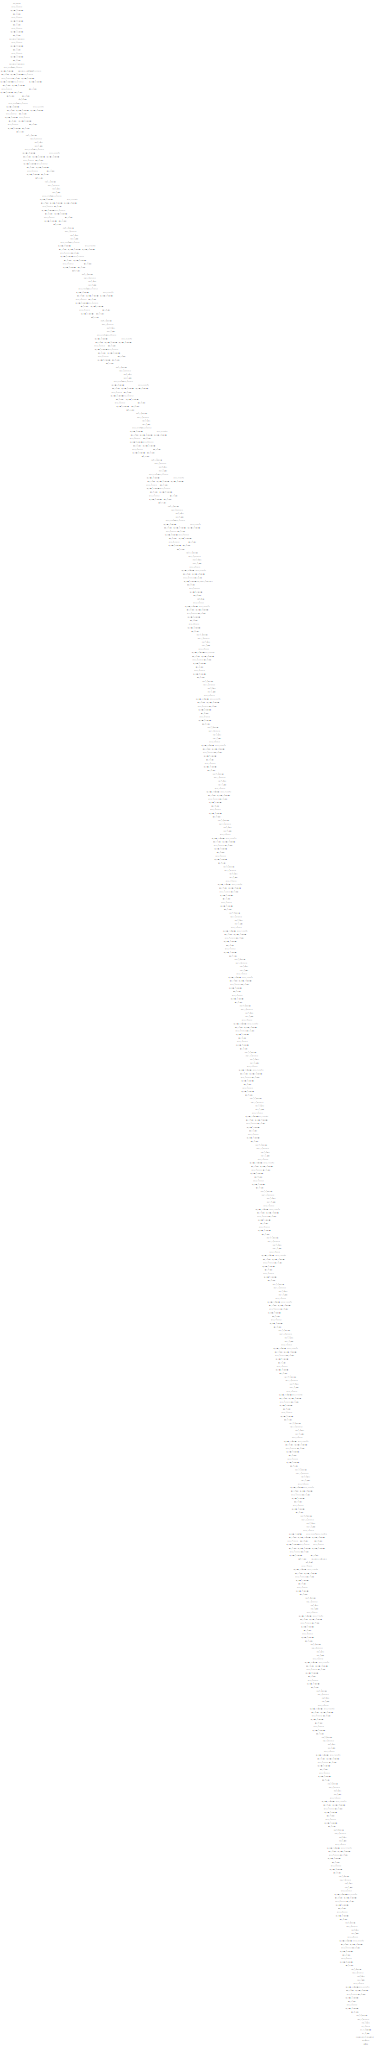

In [64]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 打印各层名称

In [65]:
for i in range(len(model.layers)):
    print(i,model.layers[i].name)

0 input_4
1 conv2d_610
2 batch_normalization_610
3 activation_610
4 conv2d_611
5 batch_normalization_611
6 activation_611
7 conv2d_612
8 batch_normalization_612
9 activation_612
10 max_pooling2d_13
11 conv2d_613
12 batch_normalization_613
13 activation_613
14 conv2d_614
15 batch_normalization_614
16 activation_614
17 max_pooling2d_14
18 conv2d_618
19 batch_normalization_618
20 activation_618
21 conv2d_616
22 conv2d_619
23 batch_normalization_616
24 batch_normalization_619
25 activation_616
26 activation_619
27 average_pooling2d_4
28 conv2d_615
29 conv2d_617
30 conv2d_620
31 conv2d_621
32 batch_normalization_615
33 batch_normalization_617
34 batch_normalization_620
35 batch_normalization_621
36 activation_615
37 activation_617
38 activation_620
39 activation_621
40 mixed_5b
41 conv2d_625
42 batch_normalization_625
43 activation_625
44 conv2d_623
45 conv2d_626
46 batch_normalization_623
47 batch_normalization_626
48 activation_623
49 activation_626
50 conv2d_622
51 conv2d_624
52 conv2d_6

## 编译模型

In [66]:
for layer in model.layers[:664]:
    layer.trainable = False
    
for layer in model.layers[664:]:
    layer.trainable = True

# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print("模型编译完成!")

模型编译完成!


## 备份模型到`json`文件

In [67]:
from keras.models import model_from_json

# 保存模型结构
model_json = model.to_json()
with open("best_model.json", "w") as json_file:
    json_file.write(model_json)
    
print("模型已经保存到json文件！")

模型已经保存到json文件！


## 训练模型

In [68]:
train_image_gen = ImageDataGenerator(rotation_range=30,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     rescale = 1./255,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     vertical_flip=False,
                                     horizontal_flip = True)
print("训练集图片:")
train_generator = train_image_gen.flow_from_directory('train1',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 color_mode="rgb",
                                                 class_mode = 'binary')

valid_image_gen = ImageDataGenerator(rescale = 1./255)

print("验证集图片:")
validation_generator = valid_image_gen.flow_from_directory('valid',
                                                 target_size = target_size,
                                                 batch_size = batch_size,
                                                 color_mode="rgb",
                                                 class_mode = 'binary')

print("len(training_generator):")
print(len(train_generator))
print("len(validation_generator):")
print(len(validation_generator))

训练集图片:
Found 19944 images belonging to 2 classes.
验证集图片:
Found 5000 images belonging to 2 classes.
len(training_generator):
312
len(validation_generator):
79


## 开始训练模型

In [69]:
# 每一轮训练需要执行的步数
steps_per_epoch = train_generator.n/train_generator.batch_size 

# 每一轮验证需要执行的步数
validation_steps = validation_generator.n/validation_generator.batch_size

print("steps_per_epoch:")
print(steps_per_epoch)
print("validation_steps:")
print(validation_steps)

steps_per_epoch:
311.625
validation_steps:
78.125


In [70]:
# 增加检查点，设置模型早停
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='final_model_weights.h5', monitor='val_loss', save_best_only=True)]

# 使用模型拟合图片数据
histpry_rec = model.fit_generator(train_generator, epochs = 10, steps_per_epoch = 312, callbacks=callbacks,
                    validation_data=validation_generator, validation_steps = 79)

Epoch 1/10
312/312 [==============================] - 464s 1s/step - loss: 0.0576 - acc: 0.9774 - val_loss: 0.0248 - val_acc: 0.9946
Epoch 2/10
312/312 [==============================] - 431s 1s/step - loss: 0.0349 - acc: 0.9872 - val_loss: 0.0155 - val_acc: 0.9952
Epoch 3/10
312/312 [==============================] - 429s 1s/step - loss: 0.0293 - acc: 0.9897 - val_loss: 0.0212 - val_acc: 0.9936
Epoch 4/10
312/312 [==============================] - 430s 1s/step - loss: 0.0268 - acc: 0.9891 - val_loss: 0.0180 - val_acc: 0.9946
Epoch 5/10
312/312 [==============================] - 430s 1s/step - loss: 0.0254 - acc: 0.9913 - val_loss: 0.0326 - val_acc: 0.9894
Epoch 6/10
312/312 [==============================] - 429s 1s/step - loss: 0.0201 - acc: 0.9925 - val_loss: 0.0325 - val_acc: 0.9914
Epoch 7/10
312/312 [==============================] - 429s 1s/step - loss: 0.0241 - acc: 0.9917 - val_loss: 0.0323 - val_acc: 0.9898


## 展示训练过程

In [74]:
# Get training and test loss histories
training_loss = histpry_rec.history['loss']
val_loss = histpry_rec.history['val_loss']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

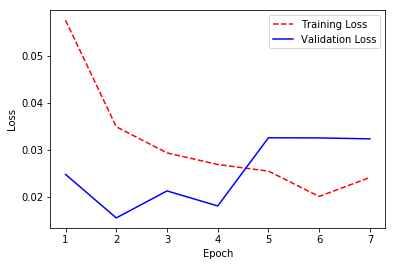

In [75]:
# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

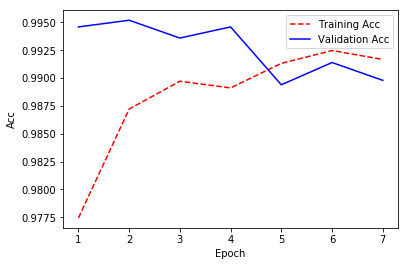

In [76]:
training_acc = histpry_rec.history['acc']
val_acc = histpry_rec.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)
# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.legend(['Training Acc', 'Validation Acc'])
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.show();

## 准备预测文件夹

In [77]:
# 测试集图片从zip包解压缩之后的存放目录
test_set_folder = 'test'
test_folder ="test1"
test_inner_folder = "test1/test"
rmrf_mkdir(test_folder)
os.mkdir(test_inner_folder)

In [78]:
def move_test_images():
    test_filenames = os.listdir(test_set_folder)
    for filename in test_filenames:
        shutil.copy2( test_set_folder + '/' + filename, test_inner_folder)


In [79]:
move_test_images()
print("开始导入测试集图片:")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_folder,
                                                  target_size=target_size, 
                                                  batch_size=batch_size,
                                                  shuffle = False, class_mode=None)

print("测试目录准备完成！")

开始导入测试集图片:
Found 12500 images belonging to 1 classes.
测试目录准备完成！


# 加载模型结构和权重

In [80]:
# 使用新的模型结构加载模型权重
json_file = open("best_model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
print("loaded_model重新加载模型权重！")
loaded_model.load_weights('final_model_weights.h5')
print("loaded_model重新加载模型权重完成！")

loaded_model重新加载模型权重！
loaded_model重新加载模型权重完成！


In [81]:
print("预测执行开始！")
pred_result = loaded_model.predict_generator(test_generator, verbose=1)
print("预测执行完毕！")

预测执行开始！
196/196 [==============================] - 70s 355ms/step
预测执行完毕！


In [82]:
test_generator.filenames[:10]

['test/1.jpg',
 'test/10.jpg',
 'test/100.jpg',
 'test/1000.jpg',
 'test/10000.jpg',
 'test/10001.jpg',
 'test/10002.jpg',
 'test/10003.jpg',
 'test/10004.jpg',
 'test/10005.jpg']

In [83]:
pred_result[:10]

array([[9.9999368e-01],
       [1.9004436e-05],
       [2.8514040e-07],
       [9.9993384e-01],
       [9.9980217e-01],
       [2.3145914e-08],
       [1.2937466e-05],
       [9.9751329e-01],
       [9.8991257e-01],
       [1.9294001e-08]], dtype=float32)

## 导出预测结果

In [84]:
import pandas as pd
from keras.preprocessing.image import *

solution = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_generator.filenames):
        index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
        solution.set_value(index-1, 'label', pred_result[i])

print("导出结果完成！")

导出结果完成！


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [85]:
solution.to_csv("pred-28.csv", index = False)
solution.head(10)

,id,label
0,1,9.999937e-01
1,2,9.999921e-01
2,3,9.998934e-01
3,4,9.999932e-01
4,5,1.622173e-05
5,6,3.194447e-07
6,7,1.824494e-08
7,8,6.633650e-07
8,9,8.750264e-07
9,10,1.900444e-05
